In [18]:
import openai
import re
import httpx
import os
from dotenv import load_dotenv

_ = load_dotenv()
from openai import OpenAI

In [19]:
client = OpenAI()
print(client)

In [20]:
chat_completion = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[{"role": "user", "content": "Hello world"}]
)
print("Wesley: This is a chat completion object.")
print(chat_completion)

Wesley: This is a chat completion object.
ChatCompletion(id='chatcmpl-BqRFopdqWVzX9t6q92supiq69sTkp', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Hello! How can I assist you today?', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None))], created=1751837520, model='gpt-3.5-turbo-0125', object='chat.completion', service_tier='default', system_fingerprint=None, usage=CompletionUsage(completion_tokens=9, prompt_tokens=9, total_tokens=18, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)))


In [12]:
print("Wesley: Within this object, there contains the context of the response to the message/query the user passed in.")
print(chat_completion.choices[0].message.content)

Wesley: Within this object, there contains the context of the response to the message/query the user passed in.
Hello there! How may I assist you today?


# Building an Agent from Stratch
Paper Link: https://react-lm.github.io

GitHub: https://github.com/ysymyth/ReAct

![react_framework](react_framework.png "ReAct Framework")

Reason Only or Chain-of-thought was an LLM's ability to reason and trace their own though. WebGPT allowed the LLM to verify factual accuracy of a language model through web browsing. The ReAct framework (Reason + Act) combines both chain-of-thought prompting with acting (e.g. WebGPT) to outperform the current benchmarks. 

A ReAct prompt sonsists of few-shot task-solving trajectories with human written text reasoning traces and actions, as well as environment observations in response to actions. The baseline (i.e. chain-of-thought) suffers from misinformation as it is not grounded to external environment (i.e. the internet) to obtain and update information and relies on internally trained data. Act-only baseline suffers from lack of reasoning, unable to synthesize the final answer.

![react_example](react_example.png "ReAct Example")

In [21]:
class Agent:
    def __init__(self, system=""):
        self.system = system
        self.messages = []
        if self.system:
            self.messages.append({"role": "system", "content": system})
 
    def __call__(self, message):
        self.messages.append({"role": "user", "content": message})
        result = self.execute()
        self.messages.append({"role": "assistant", "content": result})
        return result

    def execute(self):
        completion = client.chat.completions.create(
                        model="gpt-4o", 
                        temperature=0,
                        messages=self.messages)
        return completion.choices[0].message.content

In [22]:
prompt = """
You run in a loop of Thought, Action, PAUSE, Observation.
At the end of the loop you output an Answer
Use Thought to describe your thoughts about the question you have been asked.
Use Action to run one of the actions available to you - then return PAUSE.
Observation will be the result of running those actions.

Your available actions are:

calculate:
e.g. calculate: 4 * 7 / 3
Runs a calculation and returns the number - uses Python so be sure to use floating point syntax if necessary

average_dog_weight:
e.g. average_dog_weight: Collie
returns average weight of a dog when given the breed

Example session:

Question: How much does a Bulldog weigh?
Thought: I should look the dogs weight using average_dog_weight
Action: average_dog_weight: Bulldog
PAUSE

You will be called again with this:

Observation: A Bulldog weights 51 lbs

You then output:

Answer: A bulldog weights 51 lbs
""".strip()

In [ ]:
def calculate(what):
    return eval(what) # evaluates a string

def average_dog_weight(name):
    if name in "Scottish Terrier": 
        return("Scottish Terriers average 20 lbs")
    elif name in "Border Collie":
        return("a Border Collies average weight is 37 lbs")
    elif name in "Toy Poodle":
        return("a toy poodles average weight is 7 lbs")
    else:
        return("An average dog weights 50 lbs")

## the keys are just strings (action name that the LLM says)
## the values are the actual python function objects (not just names), but the function reference

## this known_actions["calculate"] is the function calculate
known_actions = {
    "calculate": calculate,
    "average_dog_weight": average_dog_weight
}

In [ ]:
abot = Agent(prompt)
print(abot)

In [25]:
result = abot("How much does a toy poodle weigh?")
print(result)

Thought: I should look up the average weight of a Toy Poodle using the average_dog_weight action.
Action: average_dog_weight: Toy Poodle
PAUSE


In [27]:
result = average_dog_weight("Toy Poodle")
result

'a toy poodles average weight is 7 lbs'

In [28]:
next_prompt = "Observation: {}".format(result)

In [29]:
abot(next_prompt)

'Answer: A Toy Poodle weighs an average of 7 lbs.'

In [30]:
abot.messages

[{'role': 'system',
  'content': 'You run in a loop of Thought, Action, PAUSE, Observation.\nAt the end of the loop you output an Answer\nUse Thought to describe your thoughts about the question you have been asked.\nUse Action to run one of the actions available to you - then return PAUSE.\nObservation will be the result of running those actions.\n\nYour available actions are:\n\ncalculate:\ne.g. calculate: 4 * 7 / 3\nRuns a calculation and returns the number - uses Python so be sure to use floating point syntax if necessary\n\naverage_dog_weight:\ne.g. average_dog_weight: Collie\nreturns average weight of a dog when given the breed\n\nExample session:\n\nQuestion: How much does a Bulldog weigh?\nThought: I should look the dogs weight using average_dog_weight\nAction: average_dog_weight: Bulldog\nPAUSE\n\nYou will be called again with this:\n\nObservation: A Bulldog weights 51 lbs\n\nYou then output:\n\nAnswer: A bulldog weights 51 lbs'},
 {'role': 'user', 'content': 'How much does a 

In [31]:
abot = Agent(prompt)

In [32]:
question = """I have 2 dogs, a border collie and a scottish terrier. \
What is their combined weight"""
abot(question)

'Thought: I need to find the average weight of both a Border Collie and a Scottish Terrier, then add them together to get the combined weight.\nAction: average_dog_weight: Border Collie\nPAUSE'

In [33]:
next_prompt = "Observation: {}".format(average_dog_weight("Border Collie"))
print(next_prompt)

Observation: a Border Collies average weight is 37 lbs


In [34]:
abot(next_prompt)

'Action: average_dog_weight: Scottish Terrier\nPAUSE'

In [35]:
next_prompt = "Observation: {}".format(average_dog_weight("Scottish Terrier"))
print(next_prompt)

Observation: Scottish Terriers average 20 lbs


In [36]:
abot(next_prompt)

'Thought: Now that I have the average weights of both the Border Collie and the Scottish Terrier, I can calculate their combined weight.\nAction: calculate: 37 + 20\nPAUSE'

In [37]:
next_prompt = "Observation: {}".format(eval("37 + 20"))
print(next_prompt)

Observation: 57


In [38]:
abot(next_prompt)

'Answer: The combined weight of a Border Collie and a Scottish Terrier is 57 lbs.'

In [39]:
abot.messages

[{'role': 'system',
  'content': 'You run in a loop of Thought, Action, PAUSE, Observation.\nAt the end of the loop you output an Answer\nUse Thought to describe your thoughts about the question you have been asked.\nUse Action to run one of the actions available to you - then return PAUSE.\nObservation will be the result of running those actions.\n\nYour available actions are:\n\ncalculate:\ne.g. calculate: 4 * 7 / 3\nRuns a calculation and returns the number - uses Python so be sure to use floating point syntax if necessary\n\naverage_dog_weight:\ne.g. average_dog_weight: Collie\nreturns average weight of a dog when given the breed\n\nExample session:\n\nQuestion: How much does a Bulldog weigh?\nThought: I should look the dogs weight using average_dog_weight\nAction: average_dog_weight: Bulldog\nPAUSE\n\nYou will be called again with this:\n\nObservation: A Bulldog weights 51 lbs\n\nYou then output:\n\nAnswer: A bulldog weights 51 lbs'},
 {'role': 'user',
  'content': 'I have 2 dogs,

# Looping

In [ ]:
action_re = re.compile('^Action: (\w+): (.*)$')   # python regular expression to selection action

In [41]:
def query(question, max_turns=5):
    i = 0
    bot = Agent(prompt)
    next_prompt = question
    while i < max_turns: 
        i+=1
        result = bot(next_prompt)
        print(result)
        actions = [
            action_re.match(a) 
            for a in result.split('\n') 
            if action_re.match(a)
        ]
        if actions:
            # if there is an action to run
            action, action_input = actions[0].groups()
            if action not in known_actions:
                raise Exception("Unknown action: {}: {}".format(action, action_input))
            print(" -- running {} {}".format(action, action_input))
            observation = known_actions[action](action_input)
            print("Observation:", observation)
            next_prompt = "Observation: {}".format(observation)
        else:
            return
            

In [42]:
question = """I have 2 dogs, a border collie and a scottish terrier. \
What is their combined weight"""
query(question)

Thought: I need to find the average weight of both a Border Collie and a Scottish Terrier, then add them together to find the combined weight.
Action: average_dog_weight: Border Collie
PAUSE
 -- running average_dog_weight Border Collie
Observation: a Border Collies average weight is 37 lbs
Action: average_dog_weight: Scottish Terrier
PAUSE
 -- running average_dog_weight Scottish Terrier
Observation: Scottish Terriers average 20 lbs
Thought: Now that I have the average weights of both dogs, I can calculate their combined weight by adding the two values together.
Action: calculate: 37 + 20
PAUSE
 -- running calculate 37 + 20
Observation: 57
Answer: The combined average weight of a Border Collie and a Scottish Terrier is 57 lbs.


I register my functions within a python dictionary

``` python 
known_actions = {
    "calculate": calculate,
    "average_dog_weight": average_dog_weight
}
```

where:
- keys are just strings (action name that LLM says)
- values are the actual python function objects (not their name but the function references)

So `known_actions["calculate"]` is the function `calculate`.

Within my `query` loop, the LLM returns something like:
```
Action: calculate: 4 * 7 / 3
```
The code use a **regex** or **regular expression** to parse that string

```python
action, action_input = actions[0].groups()
```

The function call is done:
```python
observation = known_actions[action](action_input)
```



# Building AI Agents using LangGraph


<img src="langchain_prompts.png" alt="LangChain Prompts" title="LangChain Tools" width="400">

Prompts are reuseable from the Hub

<img src="langchain_tools.png" alt="LangChain Tools" title="LangChain Tools" width="400">

The most code that needs to be written are loops. LangGraph helps describe the control flow of an AI system. You can create cyclic graphs, allow persistence, and Human-in-the-loop features. 


<img src="agents_from_paper_architecture.png" alt="Graphs" title="Graphs" width="400">

- LangGraph is an extension of LangChain that support graph that support single and multi agent flows that are represented as graphs 
Terminology
- Nodes: agents or functions 
- Edges: connect nodes
- Conditional Edges: decision about which node to go to next

<img src="agent_state.png" alt="Agent State" title="Agent State" width="400">

- Agent State is accessible to all parts of the graph and is local to the graph
- Can be stored in persistents layer such that it can be accessed at any time
- Agent State stores: `chat_history`, `agent_outcome`, `intermediate_steps`



In [8]:
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv())

In [29]:
from langgraph.graph import StateGraph, END ##loading in the states
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

## LangChain Tools
Link: https://python.langchain.com/api_reference/community/tools.html

There are a bunch of tools accessible from LangChain that can be used. 

In [28]:
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [ ]:
## Annotated List of message from the Agent
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [24]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [25]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
abot = Agent(model, [tool], system=prompt)
# ^ the tool used is what is below
#tool = TavilySearchResults(max_results=2) 

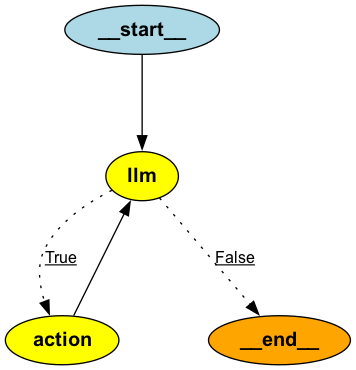

In [26]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [30]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_h8x8ahfsqENfRIlZuudr1w2j', 'type': 'tool_call'}
Back to the model!


In [31]:
result

{'messages': [HumanMessage(content='What is the weather in sf?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_h8x8ahfsqENfRIlZuudr1w2j', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BqjP06jzQUZwbeleGIKRaUBpywoMf', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c0d35e91-fb50-4152-8f54-df00aa7f144b-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, '

In [33]:
result['messages'][-1].content

"The weather in San Francisco in July is comfortable with temperatures ranging from a low of 14°C to a high of 25°C. There is little to no rain during July in San Francisco, making it easier to explore the city. If you are planning to visit San Francisco in the near future, it's recommended to review the 14-day weather forecast before you arrive."

In [34]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_P2Z1Q7itKCDIyU7jFvMqxMoe', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_Vamzyoypaijg1hrposX9SndO', 'type': 'tool_call'}
Back to the model!


In [36]:
result['messages'][-1].content
result['messages'][-1].content
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]
model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': '2024 Super Bowl winner'}, 'id': 'call_vE6Xzd9Cr1ku3Nl2WvLazHjb', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Kansas City Chiefs headquarters location'}, 'id': 'call_WSTqTP2b4rzIflvNXfNRXG7N', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'GDP of Missouri 2024'}, 'id': 'call_q9HgO83p9tqACGyS0vG79OvF', 'type': 'tool_call'}
Back to the model!


In [37]:
print(result['messages'][-1].content)

1. The Super Bowl in 2024 was won by the Kansas City Chiefs.

2. The headquarters of the Kansas City Chiefs is located in Kansas City, Missouri.

3. The GDP of Missouri in 2024 was approximately $461 billion.


# Agentic Search Tool

<img src="agentic_search.png" alt="Agentic Search" title="Agentic Search" width="400">

An agent can use search tool in order to be make better responses given accurate information from searching (similar to WebGPT)

<img src="searchtool_impl.png" alt="Agentic Search" title="Agentic Search" width="400">
Under the hood, when a user passes in a query, the agent can use sub-queries (i.e. chain-of-thought) to break down the tasks into sub-tasks. Then, each task that the agent layed out can be searched for using RAG from online sources. Using these sources, the agent will accuracy score and filter the sources to find the best K returns. 

# Persistence and Streaming
- Persistence allows you to maintain your AgentState at a given time and allows you to access this information
- Streaming you can emit signals of what's going on during that moment


In [57]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [60]:
# this is an in memory database
# when you refresh the notebook this should disappear
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

In [62]:
class Agent:
    def __init__(self, model, tools, checkpointer, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges("llm", self.exists_action, {True: "action", False: END})
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(checkpointer=checkpointer)
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [63]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""
model = ChatOpenAI(model="gpt-4o")
abot = Agent(model, [tool], system=prompt, checkpointer=memory)

In [64]:
# add streaming
message = [HumanMessage(content="what is the weather in sf")]

In [65]:
thread = {"configurable": {"thread_id": "1"}}

In [66]:
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v['messages'])

AttributeError: '_GeneratorContextManager' object has no attribute 'get_next_version'

In [67]:
messages = [HumanMessage(content="What about in la?")]
thread = {"configurable": {"thread_id": "1"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

AttributeError: '_GeneratorContextManager' object has no attribute 'get_next_version'

In [ ]:
messages = [HumanMessage(content="Which one is warmer?")]
thread = {"configurable": {"thread_id": "1"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

In [ ]:
messages = [HumanMessage(content="Which one is warmer?")]
thread = {"configurable": {"thread_id": "2"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

In [ ]:
from langgraph.checkpoint.aiosqlite import AsyncSqliteSaver

memory = AsyncSqliteSaver.from_conn_string(":memory:")
abot = Agent(model, [tool], system=prompt, checkpointer=memory)

In [ ]:
messages = [HumanMessage(content="What is the weather in SF?")]
thread = {"configurable": {"thread_id": "4"}}
async for event in abot.graph.astream_events({"messages": messages}, thread, version="v1"):
    kind = event["event"]
    if kind == "on_chat_model_stream":
        content = event["data"]["chunk"].content
        if content:
            # Empty content in the context of OpenAI means
            # that the model is asking for a tool to be invoked.
            # So we only print non-empty content
            print(content, end="|")

# Humans in the Loop

go to the human_intervention_langchain_ai_agent.ipynb

